# Sjölunda battery sorter
## A mockup for K3 seminar 2018-10-17


This is a playground created to get a hands on experience of Machine Teaching. In Machine Teaching the user has some domain knowledge and and selects the items that the Machine Leaning-artefact (ML-artefact), is supposed to learn from. Traditionally in many Machine Learning settings a domain expert has to be a Machine Learning expert. One goal with Machine Teaching is to give the domain expert a possibility to add knowledge to the model without involving a Machine Learning expert. As in the sorting problem described below a machine could be bought that is generally good at sorting and then it can be trained by the person bying it to sort "any" items.      

In a system like this the human Teacher has to over time build an understanding of how the Machine Learning artefact learns, similar to a teaching situation with a human or an animal like a dog. A system like this differs from a conventional computer program in the sense that the Machine Leaning-artefact (ML-artefact) can generalize learned knowledge. This means that when it is presented to an item not seen before it guesses what it is.

When the system is first started it has no knowledge whatsoever of the domain it is supposed to work in and has to be fed with some initial items. Over time the ML-artefact will learn and the teacher has to monitor that the results are according to expectations.

The teacher of a system like this is expected to have domain knowledge meaning that he or she knows more around the specific problem than the ML-artefact. Over time the ML-artefact is expected to get better and better att the task at hand. Generelly this is a dynamic system where the interaction between the user and the ML-artefact is in focus. 

For this Machine Teaching setup the framework from [fast.ai](http://www.fast.ai/) is used, that framework is an extention of [PyTorch](https://pytorch.org/).

### The problem
In the example below a mockup is sketched (see image below) for the task of sorting batteries. The camera takes an image and that image is feed to the ML-artefact that returns a decisions to sort them it as **chargeable** or **alkaline**. Since the incoming batteries can be dirty, from an unseen angel or of an previously unseen brand and type classification as **chargeable** or **alkaline** can be problematic. Therefor an human domain expert monitors the work done by the ML-artefact and selects batteries that he or she thinks will make the ML-artefact's predictions more accurate.   

There needs to be a way to teach the ML-artefact both initially and over time. As a Machine Teaching problem the possibility for the user to get an overview of the results and to be able to retrain the ML-artefact is important. In this specific case there is no way of knowing how well the ML-artefact does the work without manually checking the sorted batteries.

![setup][setupimg]
_A visualisation of the setup, the batteries moves forward on the conveyer belt, the camera takes images and decides if it should be sorted as chargeable (contains Pb,Cd,Ni,Hg) or as an alkaline battery. The plate that says LABEL is for batteries that the domain expert (Teacher) selects to retrain the ML-artefact with._

### Machine learning algorithm
In this mockup a CNN (Convolutional Neural Network) is used to sort the batteries. CNN's is preferably used to classify images, in this case we use a pretrained model resnet-34 as a start. In this test we only use less than 100 images to train the model so it can be used for prediction. In this case we have taken around 5 images on each battery from different angels and divided the images in train, validation and test set. Test set is around 30% of all images. The rest of the data is labelled data (70% of total data) is divided as 70% training set and 30% validation set.


### Some information around sorting batteries
A real world solution that uses machine learning to sort batteries can be seen here [film](https://www.youtube.com/watch?feature=player_embedded&v=OugqnVO7WiU). In this case the system is probably trained by Machine Learning experts before delivery, in our case we are interested in a setup were the battery expert doesn't need to be Machine Learning expert.  
And som infomation around the problem i [general (in swedish](https://www.sopor.nu/fakta-om-sopor/vad-haender-med-din-sopa/elavfall/batterier)

[setupimg]: images/setup.jpg "Setup"

### Related material
Machine teaching:
An [An overview of machine teaching](https://arxiv.org/abs/1801.05927v1)


In [41]:
# Run this first imports etc
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import sys
import os
import zipfile
import platform
#sys.path.append("../")
from fastaiold.imports import *
print(platform.python_version())
from fastaiold.transforms import *
from fastaiold.conv_learner import *
from fastaiold.model import *
from fastaiold.dataset import *
from fastaiold.sgdr import *
from fastaiold.plots import *
# set some variables
PATH = "data/batteries_v2/batteries/"
arch=resnet34  ##Using the resnet34 model
sz=224
print(f'NVidia GPUs is called CUDA aviable {torch.cuda.is_available()}')
print(f'deep learning accelerator aviable CuDNN {torch.backends.cudnn.enabled}')

3.6.5
NVidia GPUs is called CUDA aviable True
deep learning accelerator aviable CuDNN True


## Train batteries

In [68]:
# OLD
# # Uncomment below if you need to reset your precomputed activations
# #shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name="test")
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.5, 10)
# # prints training loss, validation loss and accuracy
learn.save("batteries_1")

epoch      trn_loss   val_loss   accuracy        
    0      0.536318   4.951181   0.37037   
    1      0.409849   21.49255   0.333333        
    2      4.200267   423.110229 0.296296        
    3      6.569964   1517.833008 0.185185       
    4      15.090559  2768.397949 0.185185       
    5      18.501405  7599.656738 0.185185       
    6      28.43435   727.121887 0.814815        
    7      67.916859  958.683289 0.925926        
    8      90.888183  3042.972412 0.925926       
    9      107.690907 4438.441406 0.925926       



## Confusion matrix 

Prediction:                          
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1]
Correct: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
Recall for alkaline: 1.0
Precision for alkaline: 0.92
Recall for chargeable: 0.6
Precision for chargeable: 1.0
[[22  0]
 [ 2  3]]


### Wrong classifications in validation set

valid/chargeable/DSC_0361.jpg
Classified as: alkaline should be chargeable
valid/chargeable/DSC_0280.jpg
Classified as: alkaline should be chargeable


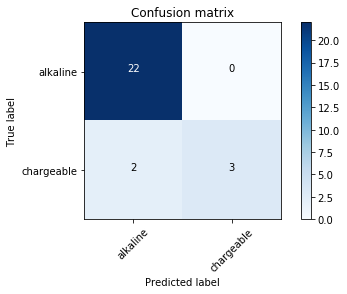

In [69]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
#print(probs)
#print(data.val_ds.fnames)
preds = np.argmax(probs, axis=1)
#print (y))    
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
#accuracy_np(probs, y)
cm = confusion_matrix(y, preds)
print("Prediction: ")
print(preds)
print("Correct: ")
print(y)
print("Recall for alkaline: "+str(np.around(cm[0,0]/(cm[0,1]+cm[0,0]),decimals=2)))
print("Precision for alkaline: "+str(np.around(cm[0,0]/(cm[0,0]+cm[1,0]),decimals=2)))
print("Recall for chargeable: "+str(np.around(cm[1,1]/(cm[1,1]+cm[1,0]),decimals=2)))
print("Precision for chargeable: "+str(np.around(cm[1,1]/(cm[1,1]+cm[0,1]),decimals=2)))
plot_confusion_matrix(cm, data.classes)

printmd("### Wrong classifications in validation set")
wrong_validation=np.where(np.add(y,preds) == 1)[0]
for i in range (0,len(wrong_validation)):
    print (data.val_ds.fnames[wrong_validation[i]])
    print("Classified as: "+data.classes[preds[wrong_validation[i]]]+" should be "+data.classes[y[wrong_validation[i]]])


In [70]:
print(wrong_validation)

[23 25]


![image](data/batteries_v2/batteries/valid/chargeable/DSC_0361.jpg)
![image](data/batteries_v2/batteries/valid/chargeable/DSC_0280.jpg)

## Predictions on test set

Sorted in accuracy order, closer to 0 the model belives it is a alkaline, closer to 1 the model belives it is a chargeable battery. So now we will know if it overfitted or included variance/bias.

In [72]:
def plot_predictions_in_accuacy_order():
    log_preds=learn.predict(is_test=True) 
    #probs = np.round(np.exp(log_preds[:,1])*100,decimals=0) ##Convert result from log scale (probs given in log...)
    probs = np.exp(log_preds[:,1])
    names = data.test_ds.fnames
    probs_sorted = np.sort(probs)
    #print(probs)
    #print(names)
    img_names_sorted_on_probs = [x for _,x in sorted(zip(probs,names))]
    img = []
    titles = []
    for i in range(0,len(data.test_ds.fnames)):
    #for i in range(0,4):
        title = PATH + img_names_sorted_on_probs[i]
        img.append(plt.imread(title))
        titles.append(data.classes[int(probs_sorted[i]+0.5)]+":"+str(np.around(probs_sorted[i],decimals=2))+":"+img_names_sorted_on_probs[i])    
    return plots(img,titles=titles,rows=5,figsize=(20,16))

plot_predictions_in_accuacy_order()

ValueError: axes don't match array

![image](data/batteries/test/DSC_0357.jpg)
![image](data/batteries/test/DSC_0355.jpg)

## Utility functions
Run this to unpack images that will be used for learning.

In [37]:
#Unpack images from zipfile to data lib
#% rm -rf (mydata/tools
with zipfile.ZipFile("data/batteries_v2.zip","r") as zip_ref:
    zip_ref.extractall("data/batteries_v2")
